In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton_krylov
from time import clock as clock
import scipy.sparse.linalg as spla

%load_ext Cython

In [4]:
# residual vector
def residual( sol_old, sol_new, Dx, D, I, Dt, M ):
        
    res = np.zeros(I, dtype = np.float64)
    
    # anode boundary condition
    res[0] = (sol_new[0] - sol_old[0] 
            + M * Dt * (-D[1] * ( sol_new[1] - sol_new[0]) / ((Dx[0] + Dx[1]) / 2) ) / Dx[0])
    
    for i in range( 1, I-1 ):

        res[i] = ( sol_new[i] -sol_old[i] 
        + M * Dt * ( -D[i+1] * ( sol_new[i+1] -  sol_new[i]) / ((Dx[i+1] + Dx[i]) / 2.0) 
                       + D[i]  * ( sol_new[i] -  sol_new[i-1]) / ((Dx[i] + Dx[i-1]) / 2.0) ) / Dx[i] )
    
    # catode boundary condition
    res[I-1] = (sol_new[I-1]- sol_old[I-1] 
                + M * Dt * (D[I] * ( sol_new[I-1] - sol_new[I-2]) / ((Dx[I-1] + Dx[I-2]) / 2.0) ) / Dx[I-1])
    
    return res

def Jacobian( I, Dx, D, Dt, M ):
    
    A = np.zeros([I,I], dtype = np.float64)
    
    # boundary i=0
    A[0,0] = 1 + 2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    A[0,1] = -2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    
    # inner points
    for i in range(1,I-1):
        A[i,i-1] = -2 * M * Dt * D[i] / ( Dx[i] * (Dx[i] + Dx[i-1]) )
        A[i,i] = 1 + 2 * M * Dt * ( D[i+1] / (Dx[i+1] + Dx[i]) + D[i] / (Dx[i] + Dx[i-1]) ) / Dx[i]
        A[i,i+1] = -2 * M * Dt * D[i+1] / ( Dx[i] * (Dx[i+1] + Dx[i]) )
    
    # boundary i=I-1
    A[I-1,I-2] = -2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    A[I-1,I-1] = 1 + 2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    
    return A

In [7]:

# time axis explicit integration
N = 1000
Dt = 1e-7
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I_vec = np.array([100, 200, 300, 400, 500, 800, 1000, 1500, 2000,3000])


# reference entities
# lengthscale = nm
L = 10 # nm
D0 = 1e-12 * 1e9 ** 2 # nm^2/s
M_vec = np.array([1e0, 1e3, 1e5, 1e7, 1e8], dtype = np.float64)


solint = np.zeros([M_vec.size,N], dtype = np.float64)
sim_time = np.zeros([M_vec.size], dtype = np.float64)

# iteration over grid points
for iterOut in range(0,1):
    
    print("Simulation number:", iterOut)
    
    I = I_vec[6]
    M = M_vec[1]
    
    # reference constants
    T0 = M * L ** 2 / D0
    
    xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )

    x = xi
    sigma = 0.005
    centers = x[:I] + (x[1:] - x[:I])
    sol_initial = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))

    # getting cell volumes
    Dx = x[1:] - x[:I]

    # init solution vector
    sol = np.zeros( [I,N], dtype = np.float64 )

    sol[:,0] = sol_initial

    D = np.ones( I+1, dtype = np.float64 )

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    J = Jacobian( I, Dx, D, Dt, M )
    J_inv = np.linalg.inv(J)

    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)

        sol[:,j] = newton_krylov( lambda y: residual(sol[:,j-1], y, Dx, D, I, Dt, M ), sol[:,j-1], inner_M = J_inv)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time[iterOut] = t2-t1

    for j in range(N):
        solint[iterOut,j] = np.dot(sol[:,j], Dx)


Simulation number: 0
Timestep  100
Timestep  200
Timestep  300
Timestep  400
Timestep  500
Timestep  600
Timestep  700
Timestep  800
Timestep  900
Simulation Time:  33.42331999999999


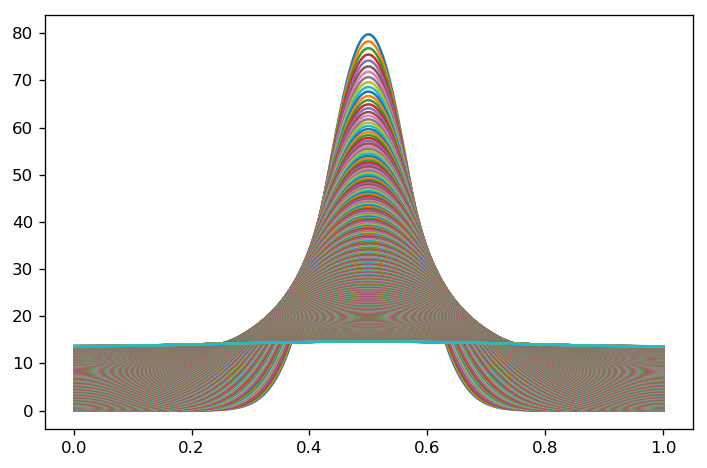

In [9]:
# scalability 
fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,1,1)

ax1.plot(centers, sol, ls = "-", marker = "None", markersize=  9)


fig.tight_layout()

plt.show()

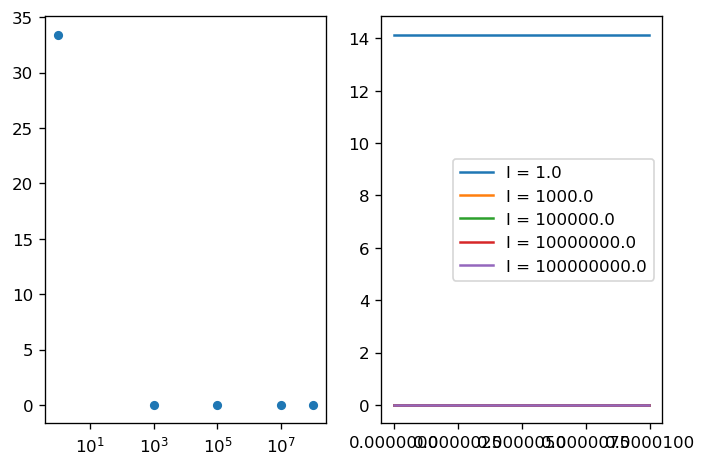

In [8]:
# scalability 
fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,2,1)

ax1.plot(M_vec, sim_time, ls = "None", marker = ".", markersize=  9)

ax1.set_xscale("log")

ax2 = fig.add_subplot(1,2,2)

for iterOut in range(0,solint.shape[0]):
    label = r"I = " + str(M_vec[iterOut])
    ax2.plot(time * T0, solint[iterOut,:], label = label)

#ax2.set_yscale("symlog", linthreshy = 1e-16)

ax2.legend()
fig.tight_layout()

plt.show()

In [12]:
%%timeit
residual(sol[:,0], sol[:,100], Dx, D, I, Dt, M )

5.59 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Changing to Cython and using Cython memviews

In [4]:
%%cython -a
import numpy as np
cimport numpy as cnp
cimport cython
from scipy.optimize import newton_krylov
import scipy.sparse.linalg as spla
from time import clock as clock

# residual vector
@cython.boundscheck(False)
@cython.wraparound(False)
def residual_cy( const double[:] sol_old,
                const double[:] sol_new,
                const double[:] Dx,
                const double[:] D,
                int I,
                double Dt,
                double M ):
    """
    Input arrays are defined as memoryviews with prefix const which declares read only buffers
    
    """
    
    # define a memview on the residual vector
    cdef:
        double[:] res = np.empty(I, dtype = np.float64)
        int i = 1
    
    # anode boundary condition
    res[0] = (sol_new[0] - sol_old[0] 
            + M * Dt * (-D[1] * ( sol_new[1] - sol_new[0]) / ((Dx[0] + Dx[1]) / 2) ) / Dx[0])
    
    for i in range( 1, I-1 ):

        res[i] = ( sol_new[i] -sol_old[i] 
        + M * Dt * ( -D[i+1] * ( sol_new[i+1] -  sol_new[i]) / ((Dx[i+1] + Dx[i]) / 2.0) 
                       + D[i]  * ( sol_new[i] -  sol_new[i-1]) / ((Dx[i] + Dx[i-1]) / 2.0) ) / Dx[i] )
    
    # catode boundary condition
    res[I-1] = (sol_new[I-1]- sol_old[I-1] 
                + M * Dt * (D[I] * ( sol_new[I-1] - sol_new[I-2]) / ((Dx[I-1] + Dx[I-2]) / 2.0) ) / Dx[I-1])
    
    return res

# Jacobian matrix
@cython.boundscheck(False)
@cython.wraparound(False)
def Jacobian_cy( int I,
                const double[:] Dx,
                const double[:] D,
                double Dt,
                double M ):
    """
    Input arrays are memviews, const is read only memview
    """
    
    cdef:
        double[:,:] A = np.zeros([I,I], dtype = np.float64)
        int i
    
    # boundary i=0
    A[0,0] = 1 + 2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    A[0,1] = -2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    
    # inner points
    for i in range(1,I-1):
        A[i,i-1] = -2 * M * Dt * D[i] / ( Dx[i] * (Dx[i] + Dx[i-1]) )
        A[i,i] = 1 + 2 * M * Dt * ( D[i+1] / (Dx[i+1] + Dx[i]) + D[i] / (Dx[i] + Dx[i-1]) ) / Dx[i]
        A[i,i+1] = -2 * M * Dt * D[i+1] / ( Dx[i] * (Dx[i+1] + Dx[i]) )
    
    # boundary i=I-1
    A[I-1,I-2] = -2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    A[I-1,I-1] = 1 + 2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    
    return A

# solver method
@cython.boundscheck(False)
@cython.wraparound(False)
def solver( int I,
           int N,
           const double[:] initial_cond,
           const double[:] Dx,
           double Dt,
           double M ):
    
    cdef:
        int j = 1
        double[:] D = np.ones( I+1, dtype = np.float64 )
    
    
    
    
    # init solution vector
    sol = np.empty( [I,N], dtype = np.float64 )
    sol[:,0] = initial_cond[:]

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    J = Jacobian_cy( I, Dx, D, Dt, M )
    J_inv = np.linalg.inv(J)
    
    M_x = lambda x: spla.spsolve(J, x)
    M_inv = spla.LinearOperator(shape = (I, I), matvec = M_x)
    
    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)

        sol[:,j] = newton_krylov( lambda y: residual_cy(sol[:,j-1], y, Dx, D, I, Dt, M ), sol[:,j-1], inner_M = J_inv)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time = t2-t1
    
    return sol, sim_time

Simulation number: 0


/home/desktop/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Timestep  100
Timestep  200
Timestep  300
Timestep  400
Timestep  500
Timestep  600
Timestep  700
Timestep  800
Timestep  900
Simulation Time:  11.567208


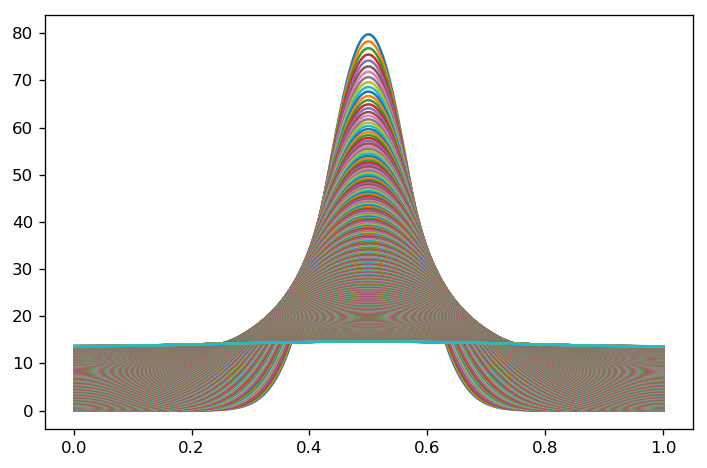

In [5]:
# time axis explicit integration
N = 1000
Dt = 1e-7
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I_vec = np.array([100, 200, 300, 400, 500, 800, 1000, 1500, 2000,3000])


# reference entities
# lengthscale = nm
L = 10 # nm
D0 = 1e-12 * 1e9 ** 2 # nm^2/s
M_vec = np.array([1e0, 1e3, 1e5, 1e7, 1e8], dtype = np.float64)


solint = np.zeros([M_vec.size,N], dtype = np.float64)
sim_time = np.zeros([M_vec.size], dtype = np.float64)

# iteration over grid points
for iterOut in range(0,1):
    
    print("Simulation number:", iterOut)
    
    I = I_vec[6]
    M = M_vec[1]
    
    # reference constants
    T0 = M * L ** 2 / D0
    
    xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )

    x = xi
    sigma = 0.005
    centers = x[:I] + (x[1:] - x[:I])
    Dx = x[1:] - x[:I]
    initial_cond = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))
    
    sol, simtime = solver( I, N, initial_cond, Dx, Dt, M )

    for j in range(N):
        solint[iterOut,j] = np.dot(sol[:,j], Dx)

fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,1,1)

ax1.plot(centers, sol, ls = "-", marker = "None", markersize=  9)


fig.tight_layout()

plt.show()

In [66]:
%%timeit
residual_cy(sol[:,0], sol[:,100], Dx, D, I, Dt, M )

58.1 µs ± 9.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Starting with numba and hopefully GPU implementation

In [9]:
import numba
from numba import jit, float64, int32
# check version
numba.__version__

'0.38.0'

In [10]:
# Numba optimization

# residual vector
@jit(float64[:] (float64[:], float64[:], float64[:], float64[:], int32, float64, float64),
     nopython=True,nogil=True,parallel=True)
def residual_nu(  sol1,
                solN,
                Dx,
                D,
                I,
                Dt,
                M ):
    """
    Input arrays are defined as memoryviews with prefix const which declares read only buffers
    
    """
    
    # define a memview on the residual vector
    res = np.empty(I, dtype = np.float64)
    
    # anode boundary condition
    res[0] = (solN[0] - sol1[0] 
            + M * Dt * (-D[1] * ( solN[1] - solN[0]) / ((Dx[0] + Dx[1]) / 2) ) / Dx[0])
    
    for i in range( 1, I-1 ):

        res[i] = ( solN[i] -sol1[i] 
        + M * Dt * ( -2.0 * D[i+1] * ( solN[i+1] -  solN[i]) / (Dx[i+1] + Dx[i]) 
                       + 2.0 * D[i]  * ( solN[i] -  solN[i-1]) / (Dx[i] + Dx[i-1]) ) / Dx[i] )
    
    # catode boundary condition
    res[I-1] = (solN[I-1]- sol1[I-1] 
                + M * Dt * (D[I] * ( solN[I-1] - solN[I-2]) / ((Dx[I-1] + Dx[I-2]) / 2.0) ) / Dx[I-1])
    
    return res

#def loopCall(  ):
    
    
    #return

# Jacobian matrix
@jit
def Jacobian_nu( I,
                Dx,
                D,
                Dt,
                M ):
    """
    Input arrays are memviews, const is read only memview
    """
    
    A = np.zeros([I,I], dtype = np.float64)
    
    # boundary i=0
    A[0,0] = 1 + 2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    A[0,1] = -2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    
    # inner points
    for i in range(1,I-1):
        A[i,i-1] = -2 * M * Dt * D[i] / ( Dx[i] * (Dx[i] + Dx[i-1]) )
        A[i,i] = 1 + 2 * M * Dt * ( D[i+1] / (Dx[i+1] + Dx[i]) + D[i] / (Dx[i] + Dx[i-1]) ) / Dx[i]
        A[i,i+1] = -2 * M * Dt * D[i+1] / ( Dx[i] * (Dx[i+1] + Dx[i]) )
    
    # boundary i=I-1
    A[I-1,I-2] = -2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    A[I-1,I-1] = 1 + 2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    
    return A

# solver method
def solver_nu( I,
           N,
           initial_cond,
           Dx,
           Dt,
           M ):
    
    D = np.ones( I+1, dtype = np.float64 )
    
    # init solution vector
    sol = np.empty( [I,N], dtype = np.float64 )
    sol[:,0] = initial_cond[:]

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    J = Jacobian_cy( I, Dx, D, Dt, M )
    J_inv = np.linalg.inv(J)

    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)

        sol[:,j] = newton_krylov( lambda y: residual_nu(sol[:,j-1], y, Dx, D, I, Dt, M ), sol[:,j-1], inner_M = J_inv)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time = t2-t1
    
    return sol, sim_time

Simulation number: 0
Timestep  100
Timestep  200
Timestep  300
Timestep  400
Timestep  500
Timestep  600
Timestep  700
Timestep  800
Timestep  900
Simulation Time:  11.285967000000007


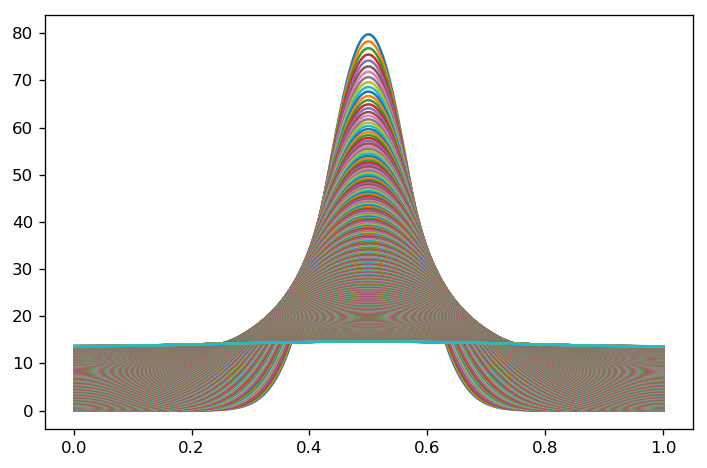

In [11]:
# time axis explicit integration
N = 1000
Dt = 1e-7
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I_vec = np.array([100, 200, 300, 400, 500, 800, 1000, 1500, 2000,3000])


# reference entities
# lengthscale = nm
L = 10 # nm
D0 = 1e-12 * 1e9 ** 2 # nm^2/s
M_vec = np.array([1e0, 1e3, 1e5, 1e7, 1e8], dtype = np.float64)


solint = np.zeros([M_vec.size,N], dtype = np.float64)
sim_time = np.zeros([M_vec.size], dtype = np.float64)

# iteration over grid points
for iterOut in range(0,1):
    
    print("Simulation number:", iterOut)
    
    I = I_vec[6]
    M = M_vec[1]
    
    # reference constants
    T0 = M * L ** 2 / D0
    
    xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )

    x = xi
    sigma = 0.005
    centers = x[:I] + (x[1:] - x[:I])
    Dx = x[1:] - x[:I]
    initial_cond = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))
    
    sol, simtime = solver_nu( I, N, initial_cond, Dx, Dt, M )

    for j in range(N):
        solint[iterOut,j] = np.dot(sol[:,j], Dx)

fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,1,1)

ax1.plot(centers, sol, ls = "-", marker = "None", markersize=  9)


fig.tight_layout()

plt.show()

In [93]:
%%timeit
residual_nu(sol[:,0], sol[:,100], Dx, D, I, Dt, M )

38 µs ± 657 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [94]:
import math
from numba import vectorize, cuda
import numpy as np

@vectorize(['float32(float32, float32, float32)',
            'float64(float64, float64, float64)'],
           target='cuda')
def cu_discriminant(a, b, c):
    return math.sqrt(b ** 2 - 4 * a * c)

N = 1e+4
dtype = np.float32

# prepare the input
A = np.array(np.random.sample(N), dtype=dtype)
B = np.array(np.random.sample(N) + 10, dtype=dtype)
C = np.array(np.random.sample(N), dtype=dtype)

D = cu_discriminant(A, B, C)

print(D)  # print result

TypeError: 'float' object cannot be interpreted as an integer